# Problem:
Humana, a health insurance company based in Louisville, Kentucky. In addition to group health insurance and both Employer Group and Individual Medicare plans, Humana offers a wide range of products and services. They offer health and supplemental insurance plans to serve all types of individuals, families, people with Medicare, servicemen, servicewomen and veterans. As part of the company's growing innovation plans, the company wanted to increase customer signup rate through their online website.

Banners take up precious space on landing pages and too often become a distraction rather than serving to draw customers to prospects.

# Potential solution:

Often the very first thing that people see when they arrive on the landing page is the banner. That means if they aren’t optimally presented, you’re going to lose customers immediately. But optimized banners can drive more prospects. 

Below is the old and new banners for the Humana website. While the old banner has too much copy that is crammed into a small space, the new banner is designed like a billboard. The new design communicate the message at a quick glance and has a clear call to action that is relevant for the customer.

<img src='SidebySide1-1024x481.png'>

# Method: 

In this study, we will record user_id, timestamps,group (old/ new landing page) and conversion (signup for Humana services). The current customer conversion rate, using the old banner, is around 12%. The aim of this experiment is to determine if replacing the banner design on the landing page for Humana website would increase user conversion rate. To determine the duration of the experiment, a power analysis was conducted to discern how many users/ group are needed to detect a 3.5% increase in conversion rate with a power of 90% (from 12% to 12.42%). 


In [154]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# set up the figure size
%matplotlib inline

# import data file
file_path = '/Users/wesamazaizeh/Desktop/Thinkful_Main_Course/ab_data.csv'
test_data = pd.read_csv(file_path)

***
## 1. Sanity chek
### 1.1. Is any of the data duplicated? 

In [2]:
nrow = test_data.shape[0]
nunique = test_data.user_id.nunique()
print('There is {} rows'.format(nrow))
print('{} of those correspond to unique user ids'.format(nunique))
print('Which means, {} entries are duplicated'.format(nrow-nunique))

There is 294478 rows
290584 of those correspond to unique user ids
Which means, 3894 entries are duplicated


### Removing duplicates. Keeping only first istance for each user

In [3]:
test_data.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [4]:
nrow = test_data.shape[0]
nunique = test_data.user_id.nunique()
print('There is {} rows'.format(nrow))
print('{} of those correspond to unique user ids'.format(nunique))
print('Which means, {} entries are duplicated'.format(nrow-nunique))

There is 290584 rows
290584 of those correspond to unique user ids
Which means, 0 entries are duplicated


### 1.2. Is all data assigned correctly?

In [5]:
error1 = test_data[(test_data['group']=='control') & (test_data['landing_page']=='new_page')].shape[0]/test_data[(test_data['group']=='control')].shape[0]
error2 = test_data[(test_data['group']=='treatment') & (test_data['landing_page']=='old_page')].shape[0]/test_data[(test_data['group']=='treatment')].shape[0]
print('{:.2}% of control group is assigned "new page" and {:.2}% of treatment group is assigned "old page"'.format(error1*100, error2*100))

0.69% of control group is assigned "new page" and 0.71% of treatment group is assigned "old page"


In [7]:
### remove users that have conflicting assignments and save them in seperate dataframe
exclude = test_data.loc[((test_data['group']=='control')&(test_data['landing_page']=='new_page'))|((test_data['group']=='treatment')&(test_data['landing_page']=='old_page'))]
exc_nrow = exclude.shape[0]
filtered_nrow = test_data.shape[0]
print('{} users that have be assigned the wrong page and will be excluded'.format(exc_nrow))
test_data.drop(exclude.index, inplace=True)
print('Which leaves {} ({:.4}%) users.'.format(filtered_nrow, filtered_nrow/(filtered_nrow+exc_nrow)*100))

2044 users that have be assigned the wrong page and will be excluded
Which leaves 290584 (99.3%) users.


## 2. Statistical Check
### 2.1. What's the probability that a user is converted regardless of landing page layout?

In [8]:
p_converted = test_data.converted.sum()/test_data.shape[0]
print('{:.4}% of users from both control and treatment groups converted'. format(p_converted*100))

11.95% of users from both control and treatment groups converted


### 2.2. What's the probability of conversion, given the user was part of the _control_ group?

In [9]:
p_control_converted = test_data.query('group == "control"')['converted']
p_control_converted = p_control_converted.sum()/p_control_converted.shape[0]
print('{:.4}% of users in control group converted'. format(p_control_converted*100))

12.03% of users in control group converted


### 2.3. What's the probability of conversion, given the user was part of the _treatment_ group?

In [10]:
p_treat_converted = test_data.query('group == "treatment"')['converted']
p_treat_converted = p_treat_converted.sum()/p_treat_converted.shape[0]
print('{:.4}% of users in control group converted'. format(p_treat_converted*100))

11.87% of users in control group converted


### 2.4. Barplot visualization of 2.1 - 2.3:

t = -1.24, p = 0.22


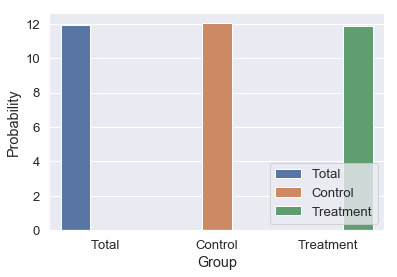

In [169]:
# visualization
barplot_data = pd.DataFrame({'Probability' : (p_converted*100, p_control_converted*100, p_treat_converted*100), 'Group' : ('Total', 'Control', 'Treatment')})
sns.set_style('whitegrid')
sns.set(font_scale=1.2)
sns.barplot(y = 'Probability', x = 'Group', hue = 'Group', data=barplot_data)
plt.legend(loc='lower right')

# T-test
t_val, p_val = stats.ttest_ind(test_data[test_data.group == 'treatment'].converted,
                          test_data[test_data.group == 'control'].converted)
print('t = {:.2f}, p = {:.2f}'.format(t_val, p_val))

### 2.5. Investigating other metrics

In [12]:
test_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


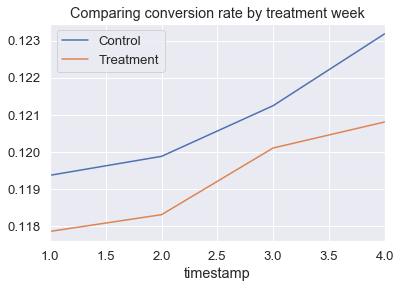

T-Test results by week
Week 1: t = -0.69, p = 0.49
Week 2: t = -0.74, p = 0.46
Week 3: t = -0.54, p = 0.59
Week 4: t = -0.53, p = 0.60


In [170]:
# Plot conversion rate by week
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], infer_datetime_format=True)
fig = control_data = test_data[test_data.group=='control'][['timestamp', 'converted']].groupby(by=[test_data['timestamp'].dt.week]).mean().plot()
treatment_data = test_data[test_data.group=='treatment'][['timestamp', 'converted']].groupby(by=[test_data['timestamp'].dt.week]).mean().plot(ax = fig)
plt.legend(['Control','Treatment'])
plt.title('Comparing conversion rate by treatment week')
plt.show()


# Generate a test statistic comparing treatment and control on treatment week
print('T-Test results by week')
test_data['week'] = test_data['timestamp'].dt.week
for week in sorted(test_data.week.unique()):
    weekly_data = test_data[ test_data.week == week ]
    t_val, p_val = stats.ttest_ind(weekly_data[weekly_data.group == 'treatment'].converted,
                          weekly_data[weekly_data.group == 'control'].converted)
    print('Week {}: t = {:.2f}, p = {:.2f}'.format(week, t_val, p_val))

## 3. Power test
### 3.1. Is the sample size big enough to detect a change?

In [120]:
# Source: http://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))
p_target = p_control_converted + p_control_converted*0.035
n = sample_power_probtest(p_control_converted, p_target, power=0.9, sig=0.05)
print("The sample size required to detect a {}% increase from control conversion rate with 90% power and p<0.05 is {}, \nwhich is 5-fold smaller than the study's sample size".format(10,n))

The sample size required to detect a 10% increase from control conversion rate with 90% power and p<0.05 is 127348, 
which is 5-fold smaller than the study's sample size


### 3.2. How many visitors per day?

In [146]:
test_data['day'] = test_data['timestamp'].dt.day
day_avg = test_data.day.value_counts().mean()
print('{:.0f} users visit the website per day on average'.format(week_avg))

12545 users visit the website per day on average


### 3.3. How long does the experiment need to run?

In [149]:
print('Therefore, the experiment needs to be ran for {:.0f} days at least ({:.0f} weeks).'.format(n*2/day_avg, n*2/day_avg/7))

Therefore, the experiment needs to be ran for 20 days at least (3 weeks).


## 4. Conclusion: